In [1]:
!pip install numpy
!pip install splitfolders
!pip install tensorflow
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install pickle
!pip install json
!pip install requests
!pip install PIL
!pip install Flask

ERROR: Could not find a version that satisfies the requirement splitfolders (from versions: none)
ERROR: No matching distribution found for splitfolders


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [14]:
import splitfolders
input_folder = "C:\\Users\\Geeth\\Downloads\\LF\\DATASET\\InputData" #Path of input dataset
output = "C:\\Users\\Geeth\\Downloads\\LF\\DATASET\\PROCESSED_DATA" #Path for output dataset
splitfolders.ratio(input_folder, output ,seed=1337 ,ratio=(.7,.15,.15))


Copying files: 7065 files [01:03, 110.47 files/s]


In [15]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization ,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np


In [16]:
img_height,img_width = (224,224)
batch_size=32
train_data_dir="C:\\Users\\Geeth\\Downloads\\LF\\DATASET\\PROCESSED_DATA\\train"
test_data_dir="C:\\Users\\Geeth\\Downloads\\LF\\DATASET\\PROCESSED_DATA\\test"
valid_data_dir="C:\\Users\\Geeth\\Downloads\\LF\\DATASET\\PROCESSED_DATA\\val"


In [17]:

train_datagen= ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4)

train_generator=train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')#set as training data

valid_generator=train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')#set as validation data

test_generator = train_datagen.flow_from_directory(
    test_data_dir,#same directory as training data
    target_size=(img_height,img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation')#set as validation data
 
x,y = test_generator.next()
x.shape


Found 3170 images belonging to 4 classes.
Found 495 images belonging to 4 classes.
Found 501 images belonging to 4 classes.


(1, 224, 224, 3)

In [18]:

base_model= ResNet50(include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions=Dense(train_generator.num_classes,activation='softmax')(x)
model= Model(inputs=base_model.input,outputs=predictions)


for layer in base_model.layers:
    layer.trainable=True


model.compile(optimizer='SGD',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(train_generator,epochs=10)

model.save('Saved_Model\ResNet50_rice_latest.h5')

test_loss,test_acc=model.evaluate(test_generator,verbose=2)

val_loss,val_acc=model.evaluate(valid_generator,verbose=2)

train_loss,train_acc=model.evaluate(train_generator,verbose=2)

print('\n Test Accuracy',test_acc)

print('\n Train Accuracy',train_acc)

print('\n Validation Accuracy',val_acc)


Epoch 1/10
100/100 [==============================] - 1036s 10s/step - loss: 0.5467 - accuracy: 0.7972
Epoch 2/10
100/100 [==============================] - 5523s 56s/step - loss: 0.2734 - accuracy: 0.9019
Epoch 3/10
100/100 [==============================] - 760s 8s/step - loss: 0.2021 - accuracy: 0.9319
Epoch 4/10
100/100 [==============================] - 988s 10s/step - loss: 0.1602 - accuracy: 0.9464
Epoch 5/10
100/100 [==============================] - 1015s 10s/step - loss: 0.1190 - accuracy: 0.9568
Epoch 6/10
100/100 [==============================] - 1017s 10s/step - loss: 0.1112 - accuracy: 0.9615
Epoch 7/10
100/100 [==============================] - 6168s 62s/step - loss: 0.1030 - accuracy: 0.9650
Epoch 8/10
100/100 [==============================] - 697s 7s/step - loss: 0.0767 - accuracy: 0.9763
Epoch 9/10
100/100 [==============================] - 788s 8s/step - loss: 0.0810 - accuracy: 0.9700
Epoch 10/10
100/100 [==============================] - 813s 8s/step - loss: 0.07

1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 136ms/step


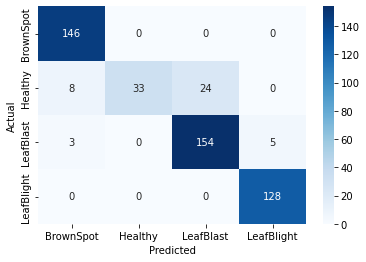

test accuracy: 92.01596806387225


In [19]:
import pandas as pd
import seaborn as sb
import tensorflow as tf


model=tf.keras.models.load_model("Saved_Model\ResNet50_rice_latest.h5")
filenames=test_generator.filenames
nb_samples=len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test=test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)


predicted_class=[list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class=[list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]


out_df=pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix=pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])


sb.heatmap(confusion_matrix,cmap='Blues', annot=True , fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))



In [23]:
from flask import Flask,request
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model,Sequential,load_model
import pickle
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img


model=load_model("C:/Users/Geeth/Downloads/LF/Models-20221015T095138Z-001/Models/ResNet50_rice_latest.h5")


app=Flask(__name__)
@app.route('/model',methods=['POST'])
def serve_model():
    requested_data=request.get_json(force=True)
    img=requested_data["img"]
    img=np.array(img).reshape(-1,224,224,3)
    prediction=[model.predict(img).argmax()]
    if prediction==[0]:
        return ("Plant is suffering from Bacterial Leaf Blight. Use balanced amounts of plant nutrients, especially nitrogen. Ensure good drainage of fields in conventionally flooded crops and nurseries. Keep fields clean. Remove weed hosts and plow under rice stubble straw rice ratoons and volunteer seedlings which can serve as hosts of bacteria.Allow fallow fields to dry in order to suppress disease agents in the soil and plant residues")
        
    elif prediction==[1]:
        return ("Plant is suffering from Brown Spot.Application of edifenphos, chitosan, iprodione, or carbendazim in the field is also advisable.Spray Mancozeb (2.0g/lit) or Edifenphos (1ml/lit) - 2 to 3 times at 10 - 15 day intervals.Grisepfulvin, Nystatin, Aureofungin, and similar antibiotics have been found effective in preventing primary seedling infection.")
    
    elif prediction==[2]:
        return ("Plant is Healthy")
    
    elif prediction==[3]:
        return ("Plant is suffering from Hispa.Avoid over fertilizing the field.Close plant spacing results in greater leaf densities that can tolerate higher hispa numbers.Leaf tip containing blotch mines should be destroyed.Manual collection and killing of beetles – hand nets.To prevent egg laying of the pests, the shoot tips can be cut.Clipping and burying shoots in the mud can reduce grub populations by 75 - 92%.Spraying of methyl parathion 0.05% or Quinalphos 0.05%.")
    
    else:
        return ("Plant is suffering from LeafBlast.Prepare to use fungicide,Systemic fungicides like triazoles and strobilurins can be used to control blast.Silicon fertilizers (e.g., calcium silicate) can be applied to soils that are silicon deficient to reduce blast.Avoid excessive nitrogen application rates and apply no more than 30 pounds per acre of nitrogen per application at midseason.")
       
    


if  __name__ == "__main__":
    app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


1/1 [==============================] - 1s 1s/step


127.0.0.1 - - [27/Nov/2022 23:22:37] "POST /model HTTP/1.1" 200 -


1/1 [==============================] - 0s 102ms/step


127.0.0.1 - - [27/Nov/2022 23:24:04] "POST /model HTTP/1.1" 200 -


1/1 [==============================] - 0s 102ms/step


127.0.0.1 - - [27/Nov/2022 23:24:37] "POST /model HTTP/1.1" 200 -


1/1 [==============================] - 0s 115ms/step


127.0.0.1 - - [27/Nov/2022 23:26:22] "POST /model HTTP/1.1" 200 -


1/1 [==============================] - 0s 141ms/step


127.0.0.1 - - [27/Nov/2022 23:27:14] "POST /model HTTP/1.1" 200 -


1/1 [==============================] - 0s 108ms/step


127.0.0.1 - - [27/Nov/2022 23:30:07] "POST /model HTTP/1.1" 200 -


1/1 [==============================] - 0s 105ms/step


127.0.0.1 - - [27/Nov/2022 23:30:44] "POST /model HTTP/1.1" 200 -


1/1 [==============================] - 0s 121ms/step


127.0.0.1 - - [27/Nov/2022 23:31:35] "POST /model HTTP/1.1" 200 -


1/1 [==============================] - 0s 99ms/step


127.0.0.1 - - [27/Nov/2022 23:31:41] "POST /model HTTP/1.1" 200 -


1/1 [==============================] - 0s 102ms/step


127.0.0.1 - - [27/Nov/2022 23:31:52] "POST /model HTTP/1.1" 200 -


1/1 [==============================] - 0s 106ms/step


127.0.0.1 - - [27/Nov/2022 23:33:42] "POST /model HTTP/1.1" 200 -


1/1 [==============================] - 0s 102ms/step


127.0.0.1 - - [27/Nov/2022 23:34:01] "POST /model HTTP/1.1" 200 -
